In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from numba import jit
import numba

In [2]:
with open('gausses.npy', 'rb') as f:
    inputt = np.load(f)
    output = np.load(f)
    # sliced_tensor = np.load(f)
    # sq_deriv_tensor = np.load(f)

In [4]:
with tf.device('/gpu:0'):
    inputt=tf.constant(inputt)
    output=tf.constant(output)
    # sliced_tensor=tf.constant(sliced_tensor,dtype=tf.float32)
    # sq_deriv_tensor=tf.constant(sq_deriv_tensor,dtype=tf.float32)

2022-01-28 12:40:39.104747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 12:40:42.027332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-01-28 12:40:42.028641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9648 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5
2022-01-28 12:40:42.029473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/tas

In [24]:
output.shape

TensorShape([10000, 61, 61])

In [7]:
with tf.device('/gpu:2'):
    input2=[inputt[:,::2,i] for i in range(4)]
    output2=output[:,::2,::2]

In [8]:
print(output2.shape)
print(input2[0].shape)

(1000, 31, 31)
(1000, 31)


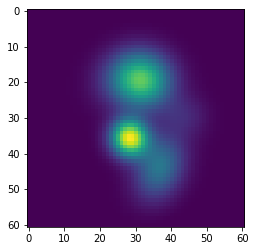

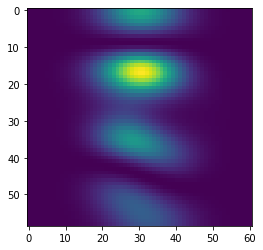

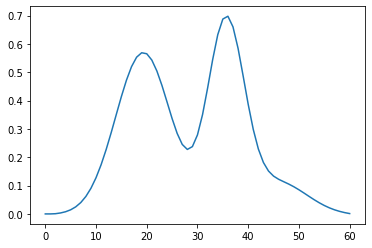

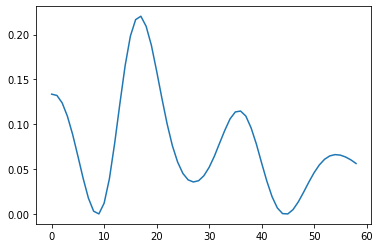

In [16]:
n=244
plt.imshow(output[n])
plt.show()
plt.imshow(sq_deriv_tensor[n,:,:,0])
plt.show()
plt.plot(output[n,:,30])
plt.show()
plt.plot(sq_deriv_tensor[n,:,30,0])
plt.show()

In [9]:
def get_siamese_model(input_shape,n_angl):
    """
        Model architecture
    """
    inputs=[layers.Input(input_shape) for _ in range(n_angl)]
    # inputs=tf.tile(layers.Input(input_shape)[tf.newaxis,:,:,:],[n_angl,1,1,1,])
    # Define the tensors for the two input images
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(layers.Conv1D(4, 5, activation='relu', input_shape=input_shape)) # kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)
    model.add(layers.MaxPooling1D())
    model.add(layers.Conv1D(8, 3, activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling1D())
    # model.add(layers.Conv1D(16, 3, activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling1D())
    # model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encodeds = tf.stack([model(input) for input in inputs], axis=1)
    # encodeds = tf.map_fn(model, inputs)
    # encodeds = tf.transpose(encodeds, perm=[1,0,2,3])
    flat_layer = layers.Flatten()(encodeds)
    dense_layer = layers.Dense(32*4, activation='relu')(flat_layer)
    flat_resalt = layers.Dense(31*31, activation='relu')(dense_layer)
    resalt = layers.Reshape((31, 31))(flat_resalt)
    # print(tf.stack(inputs,axis=3))
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=inputs,outputs=resalt)
    
    # return the model
    return siamese_net

In [10]:
model = get_siamese_model((31,1),4)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 31, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 31, 1)]      0           []                               
                                                                                              

In [12]:
with tf.device('/gpu:0'):
    model.fit(input2, output2, epochs = 100, validation_split=0.1, verbose=1)

2022-01-28 12:25:34.553340: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 109.0KiB (rounded to 111616)requested by op StridedSlice
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-28 12:25:34.553454: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-01-28 12:25:34.553498: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 19, Chunks in use: 19. 4.8KiB allocated for chunks. 4.8KiB in use in bin. 324B client-requested in use in bin.
2022-01-28 12:25:34.553532: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 896B client-requested in use in bin.
2022-01-28 12:25:34.553564: I tensorflo

ResourceExhaustedError: OOM when allocating tensor with shape[900,31] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StridedSlice] name: strided_slice/

 allocator GPU_0_bfc


In [ ]:
predictions = model.predict(input2)

In [ ]:
N = 901
plt.imshow(predictions[N])
plt.show()
plt.imshow(output.numpy()[N])